In [6]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

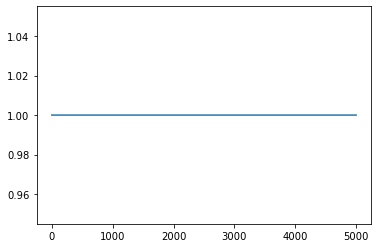

In [7]:
ell = np.arange(0, 5000)
DlTT = np.ones_like(ell) 
# DlTT[999:1100] = 4000
plt.plot(ell, DlTT)

In [8]:
def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
#     im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('temperature [uK]', rotation=270)
    
    plt.show()
    return(0)

In [26]:
## variables to set up the size of the map
N = 2**8  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400 # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


"makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
"the pixel size (pix_size) required and the number N of pixels in the linear dimension."
#np.random.seed(100)
# convert Dl to Cl
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.

# make a 2D real space coordinate system
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
# compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
# in range(N), which is just N rows copies of inds - for the x dimension
X = np.outer(onesvec,inds) 
# compute the transpose for the y dimension
Y = np.transpose(X)
# radial component R
R = np.sqrt(X**2. + Y**2.)

/tmp/ipykernel_43926/2930400760.py:17: RuntimeWarning: divide by zero encountered in true_divide
  ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))


/tmp/ipykernel_43926/1319393831.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(CLTT2d))


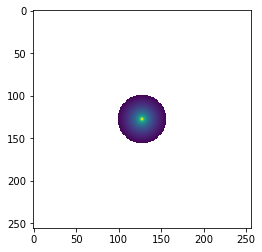

In [27]:
# now make a 2D CMB power spectrum
pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
ClTT_expanded = np.zeros(int(ell2d.max())+1) 
# making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

# the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
CLTT2d = ClTT_expanded[ell2d.astype(int)] 
plt.imshow(np.log(CLTT2d))

In [28]:
# now make a realization of the CMB with the given power spectrum in real space
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 

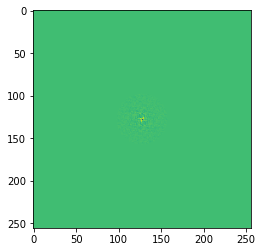

In [29]:
FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
plt.imshow(np.real(FT_2d))

map mean: -0.7205040143904377 map rms: 1.736206719891749


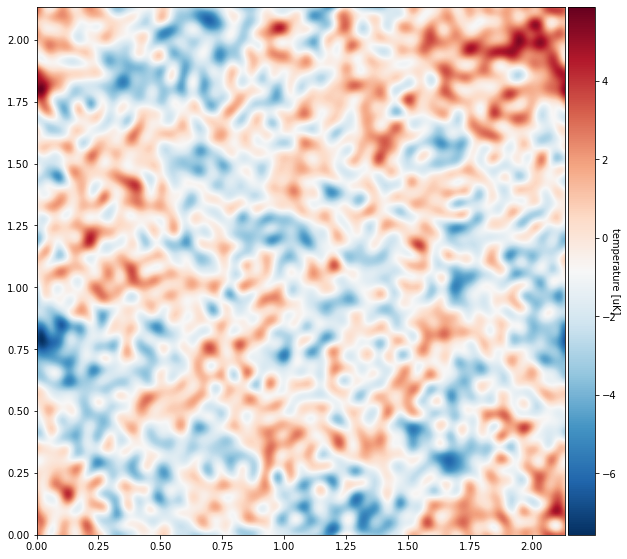

0

In [30]:
## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
#     Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###

# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
# we only want to plot the real component
CMB_T = np.real(CMB_T)



Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)

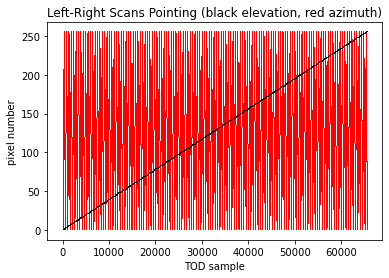

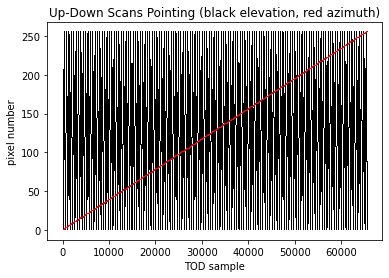

In [32]:
## a function to return the sequence of pixel indices as they are "observed" in these simualtions
def sim_pointing(map, dir=0):
    """Simulate a telescope scanning across the given map. The scanning pattern is
    as simple as possible: The samples hit the center of each pixel, and we
    scan rowwise (dir=0) or columnwise (dir=1)."""
    # The pointing is an [{y,x},nsamp] array of pixel positions
    # The einsum stuff is just to swap the second and third axis
    # of pixmap, which contains the pixel coordinates of each pixel.
    pixmap = np.mgrid[:map.shape[-2],:map.shape[-1]]  ## makes two arrays of the x and y indices in the map
    pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]          ## reverse ever other row so the scans go back and forth
    if dir == 0: point = pixmap.reshape(2,-1)         ## arranges these for L-R scans
    else:        point = np.roll(pixmap,1,axis=0).reshape(2,-1)   ## arranges these for U-D scans
    return point


sky = CMB_T

## generate left-right scans
point_lr = sim_pointing(sky, 0)

## generate Up-Down scans
point_ud = sim_pointing(sky, 1)




plt.plot(point_lr[1,:],"r,")
plt.plot(point_lr[0,:],"k,")
plt.title("Left-Right Scans Pointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
# plt.xlim(0,1e6)
plt.show()

plt.plot(point_ud[0,:],"k,")
plt.plot(point_ud[1,:],"r,")
plt.title("Up-Down Scans Pointing (black elevation, red azimuth)")
plt.ylabel("pixel number")
plt.xlabel("TOD sample")
# plt.xlim(0,1e6)
plt.show()


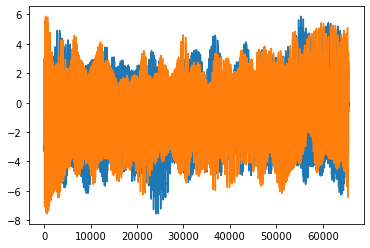

In [34]:
def Observe_map(map, point):
    """Pointing matrix: Project map to tod"""
    point = np.round(point).astype(int)
    return map[point[0],point[1]]  ## return the value of the map at each pointing, this forms the simulated time stream



noiseless_tod_lr = Observe_map(sky, point_lr)
noiseless_tod_ud = Observe_map(sky, point_ud)



plt.plot(noiseless_tod_lr)
plt.plot(noiseless_tod_ud)
plt.show()

In [18]:
#Construct a pointing matrix, apply it to "sky" and see if we can recover the results from "ObserveMap()"
from scipy.linalg import block_diag

In [41]:
A = np.eye(N)
B = np.flip(np.eye(N), axis=1)
P_lr = block_diag(A, B)

for i in range(7):
    P_lr = block_diag(P_lr, P_lr)
    

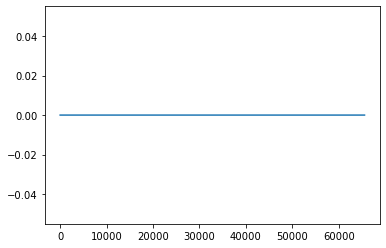

In [17]:
sparse.csr_matrix()
P = np.vstack([np.eye(N), np.flip(np.eye(N)[:-1], axis=1)])
P_onepass = np.copy(P)

n_pass=0
for i in range(n_pass):
    P = np.vstack([P, P_onepass]) #pointing matrix that traverses the map n_pass times
P = np.vstack([P, np.vstack([np.eye(len(m)), np.flip(np.eye(len(m)), axis=1)])])
nsamp = P.shape[0]
nsamp

NameError: name 'm' is not defined

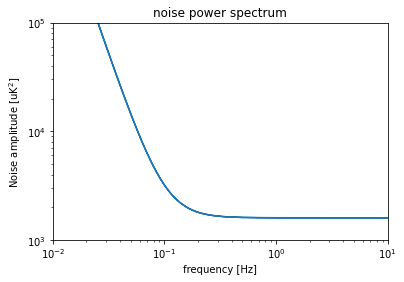

In [76]:
def sim_noise_spec(nsamp, dt=.00416, fknee=0.1, alpha=3, sigma=40):
    """Build a simple atmosphere + white noise model, and return it
    as a power spectrum."""
    freq   = np.abs(np.fft.fftfreq(nsamp, dt))
    return (1+(np.maximum(freq,freq[1])/fknee)**-alpha)*sigma**2



noise_spec_lr = sim_noise_spec(point_lr.shape[-1], dt=.00416, fknee=0.1, alpha=3, sigma=40)
noise_spec_ud = sim_noise_spec(point_ud.shape[-1], dt=.00416, fknee=0.1, alpha=3, sigma=40)
freq   = np.abs(np.fft.fftfreq(point_lr.shape[-1], .00416))

plt.loglog(freq,noise_spec_lr)
plt.title("noise power spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Noise amplitude [uK$^{2}$]")
plt.ylim(1e3,1e5)
plt.xlim(1e-2,10)
plt.show()

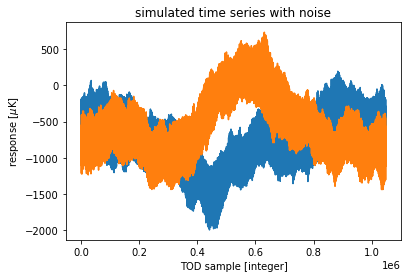

In [77]:
def sim_tod(map, point, noise_spec):
    """Simulate a noisy TOD using the model d = Pm + n"""
    tod    = Observe_map(map, point)
    rand   = np.fft.fft(np.random.standard_normal(tod.shape[-1]))
    fnoise = rand * noise_spec**0.5
    tod   += np.fft.ifft(fnoise).real
    return tod



tod_lr = sim_tod(sky, point_lr, noise_spec_lr)
tod_ud = sim_tod(sky, point_ud, noise_spec_ud)

plt.plot(tod_lr)
plt.plot(tod_ud)
plt.title("simulated time series with noise")
plt.ylabel("response [$\mu$K]")
plt.xlabel("TOD sample [integer]")
plt.show()